# Clustering

## 1. keyword 정제
    1) 주요 태그 추출
    - description 내용 포함 태그
    - description과 일치하는 단어가 없는 태그는 태그 그대로 사용
    - 태그 없는 187개 스튜디오는 description에서 추출한 단어 사용
     
     2) 유사 단어 묶어주기
    - WordCloudVec으로 단어간 유사도 판별

    >> 타겟 스튜디오와 동일한 태그 개수 세기

## 2. 범주형 데이터 Gower로 수치형 데이터로 변환
    1) 범주형 데이터는 category와 

In [6]:
import numpy as np 
import pandas as pd 
from pandas import DataFrame as df
import csv
from konlpy.tag import Okt
from collections import Counter

In [2]:
import os
dataset = pd.read_csv("total_dataset_trim_newTag.csv",encoding='utf-8')
dataset.tail()

,Unnamed: 0,index,NO,img_fold_no,studio_name,studio_picture,imafe_file,category,region,tag,price,area,floor,default_person,parking,description,new_tag1,new_tag2
1847,1847,1847,1804,89,홍대 2룸,['https://s3.hourplace.co.kr/image/user/841/20...,"['89_0_홍대_2룸.jpg', '89_1_홍대_2룸.jpg', '89_2_홍대_...",빌라,서울,NaN,50000,50,2,7,0,홍대에 있는 방 2개 주택입니다.,"['홍대', '주택']","['홍대', '주택']"
1848,1848,1848,1831,1,경리단길 윤싸롱 3호점 - 채광 굿 깔끔하고 모던한 자취방,['https://s3.hourplace.co.kr/image/user/6876/2...,"['1_0_경리단길_윤싸롱_3호점_-_채광_굿_깔끔하고_모던한_자취방.jpg', '...",원룸,서울,NaN,40000,33,1,3,1,낮에 채광 잘드는 1층 집이고 공간은 약 10평정도 됩니다. 드라마 이태원클라쓰 촬...,"['동네', '평정', '상품', '촬영', '자연', '공간', '드라마', '이...","['동네', '평정', '상품', '촬영', '자연', '공간', '드라마', '이..."
1849,1849,1849,1832,2,"상수역 6분거리 , 합정역 6분거리 30평급 넓은 공간 자연광 스튜디오 VILLA ...",['https://s3.hourplace.co.kr/image/user/6691/2...,"['2_0_상수역_6분거리_,_합정역_6분거리_30평급_넓은_공간_자연광_스튜디오_...",스튜디오,서울,NaN,45000,96,3,6,1,30평의 넓은 공간에 동남서 방향 3면에 창이 배치되어 자연광이 풍부하고 섹션별로 ...,"['영상', '각종', '디자인', '제품', '방향', '섹션', '활용', '평...","['영상', '각종', '디자인', '제품', '방향', '섹션', '활용', '평..."
1850,1850,1850,1840,10,시매,['https://s3.hourplace.co.kr/image/user/6818/2...,"['10_0_시매.jpg', '10_1_시매.jpg', '10_2_시매.jpg', ...",주택,서울,NaN,41000,46,4,3,2,해방촌 언저리에 있는 작은 옥탑방이예요.\r\n\r\n방문이 없는 투룸 과 주방 공...,"['주방', '사용', '우드', '음식', '찍기', '쇼핑몰', '공간', '투...","['주방', '사용', '우드', '음식', '찍기', '쇼핑몰', '공간', '투..."
1851,1851,1851,1847,17,(용산) 채광맛집 예술가의 로프트!,['https://s3.hourplace.co.kr/temp/images/2020/...,"['17_0_(용산)_채광맛집_예술가의_로프트!.jpg', '17_1_(용산)_채광...",원룸,서울,NaN,87000,26,12,3,2,안녕하세요!\r\n\r\n용산에 위치한 복층 오피스텔입니다\r\n공간이 넓지는 않지...,"['위치', '복층', '화이트', '공간', '남향', '감각', '인테리어', ...","['위치', '복층', '화이트', '공간', '남향', '감각', '인테리어', ..."


In [55]:
## description 다듬기
def getDescList(n):
    okt=Okt()
    descList=[]
    for i in range(n):
        tempList=[]
        descript=(dataset.description[i]) # 한글자 이상만 뽑음
        descript=descript.replace("\n","")
        descript=descript.replace("\r","")
        descript=descript.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣09]","")
        tempList=[j[0] for j in okt.pos(descript) if ((len(j[0])>1)& (len(j[0])<7)& (j[1]=="Noun"))]
        tempList=list(set(tempList))
        if len(tempList)>0:
            descList.append(tempList)
        else:
            descList.append(tempList)
#             print(tempList,"|",i) #빈 태그
                                    # [] | 92
                                    # [] | 988
                                    # [] | 1486
                                    # [] | 1806
    return descList

In [ ]:
# descList=getDescList(len(dataset))
# descList

In [824]:
# len(descList)

1852

In [56]:
## Tag 다듬기
## 복합명사로 이루어진 태그는 잘라서 길이 2~7 사이의 단어만 추출
def getTagList(n):
    parseTagList=[]
    okt=Okt()
    for i in range(n):
        tempTagList=[]
        tags=str(dataset.tag[i]).split('#') # 태그별로 자르기
        for tag in tags:
            if len(tag)>1:
                okt.pos(tag)  # 1개 태그 내 복합 명사 자르기
                for j in okt.nouns(tag):
                    if(len(j)>=2|len(j)<7):
                        tempTagList.append(j)
        tempTagList=list(set(tempTagList))
        parseTagList.append(tempTagList)
    return parseTagList

In [678]:
# tagList=getTagList(10)
# tagList

### CoreTag 2가지 방법

In [57]:
## Case 1) 코어 태그 추출 (태그, description 합집합)
def getCoreTags1(n):
    coreTagList1=[]
    okt=Okt()    
    coreTag=[]
    descript=getDescList(n) # 한글자 이상만 뽑음
    tags=getTagList(n)  # tag를 한번 더 파싱
    for i in range(len(descript)): 
        if (len(tags[i])>0): 
            coreTag.append(tags[i]+descript[i])
        else:
            coreTag.append(descript[i])
    coreTagList1.append(coreTag)
    return coreTagList1

In [64]:
# %time CoreTagDate1=getCoreTags1(len(dataset))
# CoreTagDate1=CoreTagDate1[0]
CoreTagDate1

Wall time: 1min 31s


[['모던',
  '원룸',
  '클래식',
  '분리',
  '홍대',
  '서울시',
  '서교동',
  '빌라',
  '거리',
  '모던',
  '그림',
  '주말',
  '클래식',
  '조성',
  '등록',
  '메인',
  '모델링',
  '분위기',
  '평일',
  '홍대',
  '체스',
  '바탕',
  '빌라',
  '예약'],
 ['명수',
  '루프',
  '벽난로',
  '고풍',
  '전망',
  '자연',
  '촬영',
  '작업',
  '침실',
  '주방',
  '쇼핑몰',
  '생활',
  '거실',
  '사용',
  '키친',
  '내부',
  '스튜디오',
  '렌트',
  '옥상',
  '게스트',
  '음악',
  '구성'],
 ['명수',
  '루프',
  '벽난로',
  '고풍',
  '전망',
  '자연',
  '촬영',
  '작업',
  '침실',
  '주방',
  '쇼핑몰',
  '생활',
  '거실',
  '사용',
  '키친',
  '내부',
  '스튜디오',
  '렌트',
  '옥상',
  '게스트',
  '음악',
  '구성'],
 ['아파트',
  '평투룸',
  '선유도',
  '신축',
  '가정',
  '욕실',
  '주방',
  '크기',
  '야경',
  '위치',
  '거실',
  '안양천',
  '시설',
  '선유도역',
  '남향',
  '느낌',
  '신축',
  '오피스텔',
  '투룸'],
 ['북향',
  '분위기',
  '쇼파',
  '서재',
  '가구',
  '촬영',
  '직장',
  '직접',
  '주방',
  '공간',
  '거실',
  '햇빛',
  '전문의',
  '부부',
  '북향',
  '평일',
  '관계',
  '신축'],
 ['신혼집',
  '빌라',
  '카페',
  '민원',
  '가까이',
  '맞은편',
  '직접',
  '친구',
  '신혼',
  '주차장',
  '드레스',
  '공원',
  '사이사이',
  '바로',
  '공용',
  

In [8]:
## Case 2) 코어 태그 추출 (부분적으로 기존 태그 + description + coreTag )
def getCoreTags2(n):
    coreTagList=[]
    okt=Okt()    
    descript=getDescList(n) # 한글자 이상만 뽑음
    tags=getTagList(n)  # tag를 한번 더 파싱
    for k in range(len(descript)):
        coreTags=[]
        for t in range(len(tags[k])):
            if (len(tags[k][t])>0)&(tags[k][t] in descript[k]): # 태그가 description 단어에도 있는지 확인
                coreTags.append(tags[k][t])
        if (len(tags[k])<=3): # 태그 수가 없으면 디스크립션으로
            coreTagList.append(descript[k])
        elif((len(tags[k])>3)&(len(coreTags)<3)):  # 디스크립션과 일치하는 태그가 없는데 기존 태그 많으면 기존 태그 사용
            coreTagList.append(tags[k])
        elif(len(coreTags)>=3): # 디스크립션과 일치하는 태그가 많으면 일치태그 사용
            coreTagList.append(coreTags)
    return coreTagList

In [33]:
# %time CoreTagDate2=getCoreTags2(1852)
CoreTagDate2

[['클래식', '홍대', '빌라', '모던'],
 ['벽난로', '전망', '루프', '고풍', '자연', '명수'],
 ['벽난로', '전망', '루프', '고풍', '자연', '명수'],
 ['선유도', '아파트', '가정', '평투룸', '신축'],
 ['햇빛',
  '주방',
  '직장',
  '북향',
  '평일',
  '전문의',
  '직접',
  '가구',
  '거실',
  '촬영',
  '신축',
  '서재',
  '관계',
  '공간',
  '부부'],
 ['위치',
  '세탁실',
  '찾기',
  '주방',
  '사용',
  '남편',
  '직접',
  '빌라',
  '서재',
  '바로',
  '건물',
  '구조',
  '주차장',
  '수원',
  '친구',
  '인테리어',
  '거실',
  '공원',
  '다이닝',
  '화장실',
  '경기도',
  '겸용',
  '여권',
  '월드컵경기',
  '드레스',
  '맞은편',
  '가까이',
  '침실',
  '공용',
  '베란다',
  '신혼',
  '주차',
  '벽돌',
  '사이사이',
  '민원'],
 ['아파트', '반포', '잠원동', '잠원역', '소형', '강남'],
 ['광고', '자취', '가구', '원룸', '여자'],
 ['라이프', '싱글', '원룸', '주거', '고시원', '천호역'],
 ['블루', '골드', '모던', '서울', '화이트'],
 ['평수', '테라스', '아이방', '복층'],
 ['아파트',
  '사항',
  '사용',
  '모두',
  '주말',
  '분장',
  '소품',
  '확장',
  '실로',
  '평일',
  '화장실',
  '관계',
  '단지',
  '개화',
  '가능',
  '시간',
  '특이',
  '남서',
  '안쪽',
  '서현역',
  '장대',
  '공사'],
 ['칸막이', '공간', '화실', '평의'],
 ['주차', '차량', '가능', '화장실', '공간'],
 ['모던', '아이방', 

In [17]:
print(len(CoreTagDate1),len(CoreTagDate2))

1852 1852


## wordcloud
    단어간 유사도

### CoreTag로 유사 키워드 추출

In [61]:
import gensim 
from gensim.models import word2vec


In [67]:
num_features = 100    # Word vector dimensionality                      
min_word_count = 3   # Minimum word count                        
num_workers = 2     # Number of threads to run in parallel
context = 4          # Context window size                                                                                    
downsampling = 1e-3  # Downsample setting for frequent words

model1 = gensim.models.Word2Vec(CoreTagDate1, workers=num_workers, 
                          size=num_features, min_count = min_word_count,
                          window = context, sample = downsampling)

# model2 = gensim.models.Word2Vec(CoreTagDate2, workers=num_workers, 
#                           size=num_features, min_count = min_word_count,
#                           window = context, sample = downsampling)

model_name = "TagSimilarity1"
model1.save(model_name)

# model_name = "TagSimilarity2"
# model2.save(model_name)

In [68]:
# model.wv.vocab
test_keyword=["가정","사진","촬영","원목","아파트","루프","자연","채광","스튜디오","광고","거실","주택","파티","빌라","카페",
              "빈티","플라워","홍대","공간","화이트","느낌","분위기","원룸",
              "사무실","서울","마당","정원","모던","인테리어","오피스"]

testkeywordDict1={}
for keyword in test_keyword:
    testkeywordDict1.update({keyword:model1.wv.most_similar(keyword,topn=5)})
testkeywordDict1

{'가정': [('빌라', 0.9998941421508789),
  ('우드', 0.9998928904533386),
  ('하우스', 0.9998810887336731),
  ('근처', 0.9998751282691956),
  ('야외', 0.9998742341995239)],
 '사진': [('장소', 0.9999364614486694),
  ('또한', 0.9999234676361084),
  ('바로', 0.9999202489852905),
  ('주변', 0.9999191761016846),
  ('공원', 0.9999162554740906)],
 '촬영': [('서울', 0.999886155128479),
  ('거리', 0.9998825788497925),
  ('채광', 0.9998745918273926),
  ('영화', 0.9998706579208374),
  ('컨셉', 0.9998608827590942)],
 '원목': [('서울', 0.9999191761016846),
  ('테라스', 0.9999175071716309),
  ('화이트', 0.9999119639396667),
  ('컨셉', 0.9999109506607056),
  ('카페', 0.9999059438705444)],
 '아파트': [('미니', 0.9999140501022339),
  ('심플', 0.9999089241027832),
  ('식물', 0.9999020099639893),
  ('바로', 0.9998905658721924),
  ('아이', 0.9998865127563477)],
 '루프': [('구성', 0.9999175071716309),
  ('옥상', 0.99989914894104),
  ('운영', 0.9998944997787476),
  ('근처', 0.9998900890350342),
  ('아주', 0.9998883008956909)],
 '자연': [('장소', 0.999932587146759),
  ('대여', 0.99989718198

In [36]:
# "편안" 키워드 반영 X
test_keyword=["가정","사진","촬영","원목","아파트","루프","자연","채광","스튜디오","광고","거실","주택","파티","빌라","카페",
              "빈티","플라워","홍대","공간","화이트","느낌","분위기","원룸",
              "사무실","서울","마당","정원","모던","인테리어","오피스"]
testkeywordDict2={}
for keyword in test_keyword:
    testkeywordDict2.update({keyword:model2.wv.most_similar(keyword,topn=5)})
testkeywordDict2

{'가정': [('촬영', 0.9971935153007507),
  ('공간', 0.9970043897628784),
  ('주말', 0.9968531727790833),
  ('거실', 0.9968520402908325),
  ('느낌', 0.9965159296989441)],
 '사진': [('느낌', 0.9967677593231201),
  ('촬영', 0.9965486526489258),
  ('주말', 0.9964958429336548),
  ('공간', 0.9964368343353271),
  ('평일', 0.9962464570999146)],
 '촬영': [('주말', 0.9983217716217041),
  ('공간', 0.9981911778450012),
  ('정원', 0.9981109499931335),
  ('아파트', 0.9979910850524902),
  ('거실', 0.9979539513587952)],
 '원목': [('가구', 0.9945619106292725),
  ('정원', 0.9943369030952454),
  ('거실', 0.9943026304244995),
  ('모던', 0.994168221950531),
  ('촬영', 0.994049072265625)],
 '아파트': [('촬영', 0.9979909658432007),
  ('느낌', 0.997343122959137),
  ('주말', 0.9973375797271729),
  ('사용', 0.9972960352897644),
  ('인테리어', 0.9972710013389587)],
 '루프': [('촬영', 0.996267557144165),
  ('공간', 0.9961527585983276),
  ('화이트', 0.9956377744674683),
  ('가구', 0.9954395294189453),
  ('주말', 0.9953470230102539)],
 '자연': [('촬영', 0.9970767498016357),
  ('아파트', 0.996676862

## 각 모델 결과 태그를 새로운 태그 (extend_tag1,extend_tag) 컬럼으로 저장

In [69]:
extendTagList1=[]
vocab=model1.wv.vocab
tagList1=[]
for i in range(len(CoreTagDate1)):
    extendTag=[]
    tag1=[]
    try:
        for j in range (len(CoreTagDate1[i])):
            if(CoreTagDate1[i][j] in vocab.keys()):
#                 print(CoreTagDate1[i][j])
                extendSet=model1.wv.most_similar(CoreTagDate1[i][j],topn=2)
                tag1.append(CoreTagDate1[i][j])
                for extend in extendSet:
                    extendTag.append(extend)
                extendTagList1.append(list(set(extendTag[0])))
            else:
                continue
        tagList1.append(tag1)
    except KeyError:
        continue

In [70]:
# dataset["new_tag1"]=tagList1
extendTagList1

[[0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999040365219116, '전망'],
 [0.9999175071716309, '구성'],
 [0.9999175071716309, '구성'],
 [0.9999175071716309, '구성'],
 [0.9999175071716309, '구성'],
 [0.9999175071716309, '구성'],
 [0.9999175071716309, '구성'],
 [0.9999175071716309, '구성'],
 [0.9999175071716309, '구성'],
 [0.9999175071716309, '구성'],
 [0.9999175071716309, '구성'],
 [0.9999175071716309, '구성'],
 [0.9999175071

In [39]:
# extendTagList2=[]
vocab=model2.wv.vocab
tagList2=[]
for i in range(len(CoreTagDate2)):
    extendTag=[]
    tag2=[]
    try:
        for j in range (len(CoreTagDate2[i])):
            if(CoreTagDate2[i][j] in vocab.keys()):
#                 print(CoreTagDate2[i][j])
                extendSet=model2.wv.most_similar(CoreTagDate2[i][j],topn=2)
                tag2.append(CoreTagDate2[i][j])
                for extend in extendSet:
                    extendTag.append(extend)
                extendTagList.append(list(set(extendTag[0])))
            else:
                continue
        tagList2.append(tag2)
    except KeyError:
        continue

In [40]:
dataset["new_tag2"]=tagList2

In [4]:
dataset.to_csv('C:/바탕 화면/playdata/ice/eclipse/Devils_Project/dataWork/controller/total_dataset_trim_newTag.csv',
                 sep=',',na_rep='NaN',index =True,encoding='utf-8-sig')

NameError: name 'dataset' is not defined

## 데이터 전처리
    1) 데이터 타입 변환
    2) scaling - 이상치 제거, 가격 컬럼 로그화, robust scaling

#### 1) 데이터 타입 변환

In [174]:
import matplotlib
import matplotlib.pyplot as plt
dataset = pd.read_csv("total_dataset_trim_newTag_scale.csv",encoding='utf-8')
import seaborn as sns

In [349]:
## price 컬럼 숫자형으로 변형
# dataset["price"].astype("float32")

## floor 컬럼 문자열 숫자로 바꾸기 (지금은 데이터에서 직접 다 바꿈... 나중에 코드 입력하기)
# dataset[dataset["floor"]=='B']["floor"].replace("B","-")
# dataset[dataset["floor"]=='지하']["floor"].replace("지하","-")
# dataset[dataset["floor"]=='-']["floor"].replace("-","-1")


In [196]:
def round_int(array):
    for x in dataset['floor']:
        if np.log(x) == float("inf") or dataset['floor'] == float("-inf") or dataset['floor'] == float("nan"):
            return x
        dataset['floor']
    return 

# sns.distplot(np.log(dataset['price']))
# sns.distplot(np.log(dataset['area']))
# sns.distplot(np.log(dataset['default_person']))

# sns.distplot(round_int(np.log(dataset['floor'])))
# sns.distplot(dataset['parking'])
# round_int()
round_int(np.log(dataset['floor']))

C:\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

#### 2) Scaling

In [179]:
# 이상치 제거
def removeOutliers(x, columns):
    columnList=[]
    for column in columns:
        # Q1, Q3구하기
        if(column=="price")|(column=="area"):
            np.log(x[column])
        q1 = x[column].quantile(0.25)
        q3 = x[column].quantile(0.75)

        # 1.5 * IQR(Q3 - Q1)
        iqt = 1.5 * (q3 - q1)
        columnList.append(x[column][(x[column] < (q3 + iqt))])
    return columnList

<AxesSubplot:xlabel='floor'>

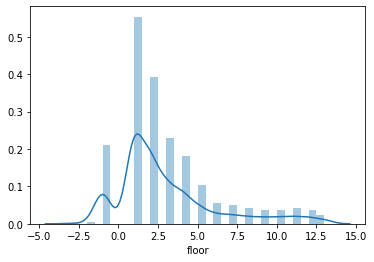

In [180]:
Outliers_to_drop = removeOutliers(dataset, ["price","area","default_person","parking","floor"])
sns.distplot(Outliers_to_drop[4])


In [51]:
# scaling
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
print(robustScaler.fit([dataset["price"]]))
train_data_robustScaled = robustScaler.transform([dataset["price"]])

RobustScaler()


array([], dtype=float64)

In [41]:
target=dataset.iloc[0]
rest=dataset.iloc[1:]

In [159]:
## 문자열로 저장된 태그 리스트로 변환
def strToList(value):
    trimList=value.replace(']','')
    trimList=trimList.replace('[','')
    trimList=trimList.replace("'",'')
    trimList=trimList.split(",")
    return trimList

In [166]:
def tagCount(targetTag):
    countKeyword=[]
    for i in range(len(rest["new_tag1"])):
        cnt=0
        for t in strToList(targetTag):
            if t in strToList(rest.iloc[i]["new_tag1"]):
                cnt+=1
        countKeyword.append(cnt)
    return countKeyword